In [35]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from src.utils import calculate_currents
from src.functions import set_time, plotting_solution_gridspec_original
from src.models import synchronous_machine_equations_SM4
from omegaconf import OmegaConf

In [45]:
# load config
config = OmegaConf.load("params/machine7.yaml")

# extract parameters
H = config.H
X_d = config.X_d
X_d_dash = config.X_d_dash
X_q = config.X_q
X_q_dash = config.X_q_dash
T_d_dash = config.T_d_dash
T_q_dash = config.T_q_dash
D = config.D

# global parameters
omega_B = 2 * np.pi * 50
Vs = 1.0
theta_vs = 0.0

# Inputs
P_m = config.P_m if "P_m" in config else 0.8
E_fd = config.E_fd if "E_fd" in config else 1.0

Relaxed equilibrium candidate:
delta*      = 1.202930
omega*      = 6.987499e-04
E_d_dash*   = 0.356879
E_q_dash*   = 0.517725


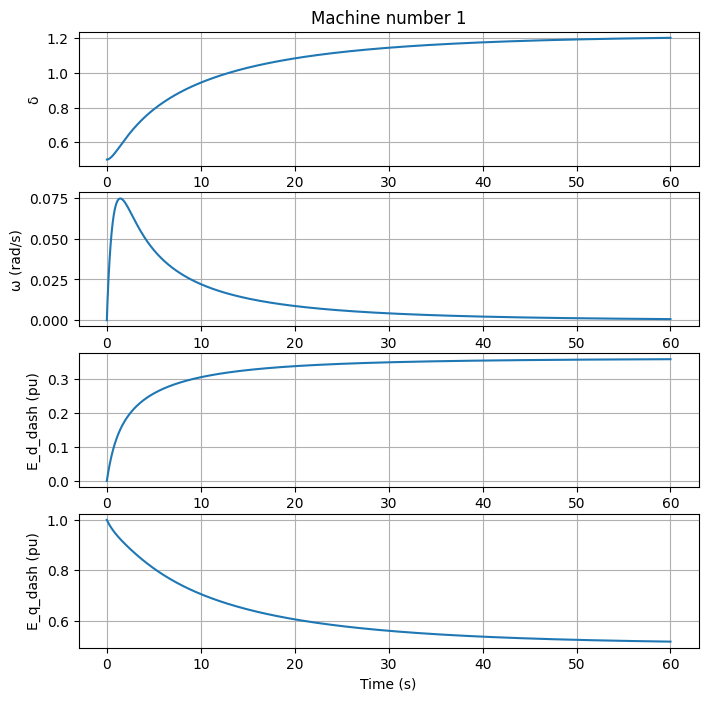

In [46]:
# find steady state initial conditions by running long simulation and taking end state
x0_guess = np.array([
    0.5,   # delta [rad]
    0.0,   # omega
    0.0,   # E_d'
    1.0    # E_q'
])

t_span, t_eval = set_time(end_time=60.0, interval_points=6000)

sol_relax = solve_ivp(
    synchronous_machine_equations_SM4,
    t_span,
    x0_guess,
    t_eval=t_eval,
    args=(
        omega_B,
        H,
        P_m,
        X_q_dash,
        X_d_dash,
        D,
        T_d_dash,
        X_d,
        E_fd,
        T_q_dash,
        X_q,
        Vs,
        theta_vs,
    ),
    rtol=1e-8,
    atol=1e-10
)

x_star = sol_relax.y[:, -1]

delta_star, omega_star, E_d_dash_star, E_q_dash_star = x_star

print("Relaxed equilibrium candidate:")
print(f"delta*      = {delta_star:.6f}")
print(f"omega*      = {omega_star:.6e}")
print(f"E_d_dash*   = {E_d_dash_star:.6f}")
print(f"E_q_dash*   = {E_q_dash_star:.6f}")

plotting_solution_gridspec_original(sol_relax, model=1)

In [47]:
dx_star = synchronous_machine_equations_SM4(
    t=0.0,
    x=x_star,
    omega_B=omega_B,
    H=H,
    P_m=P_m,
    X_q_dash=X_q_dash,
    X_d_dash=X_d_dash,
    D=D,
    T_d_dash=T_d_dash,
    X_d=X_d,
    E_fd=E_fd,
    T_q_dash=T_q_dash,
    X_q=X_q,
    Vs=Vs,
    theta_vs=theta_vs
)

dx_star = np.array(dx_star)

print("\nResidual norm ||f(x*)|| =", np.linalg.norm(dx_star))
print("Component-wise residuals:", dx_star)

# use dx_star as initial condition for further analysis
x0 = x_star.copy()


Residual norm ||f(x*)|| = 0.0008814631980630776
Component-wise residuals: [ 6.98749916e-04 -3.92446607e-05  1.02004153e-04 -5.26099737e-04]


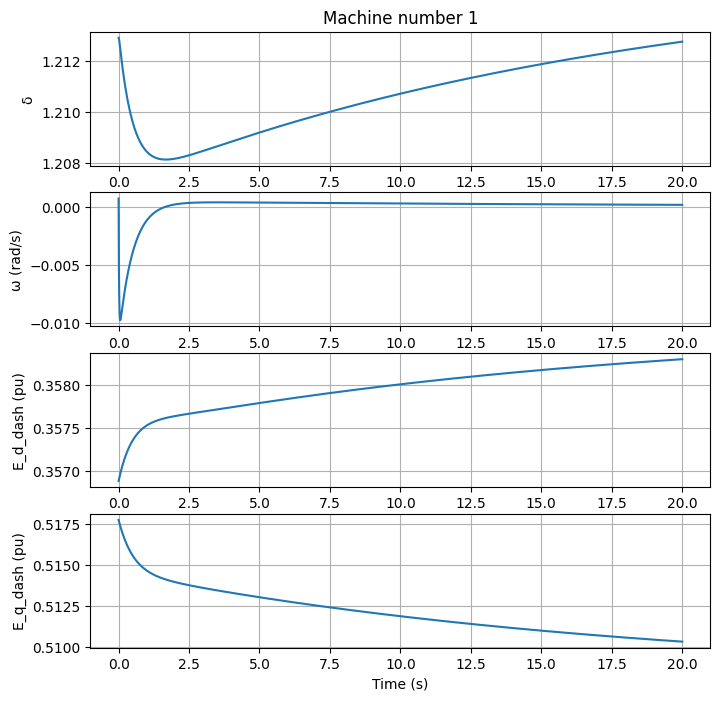

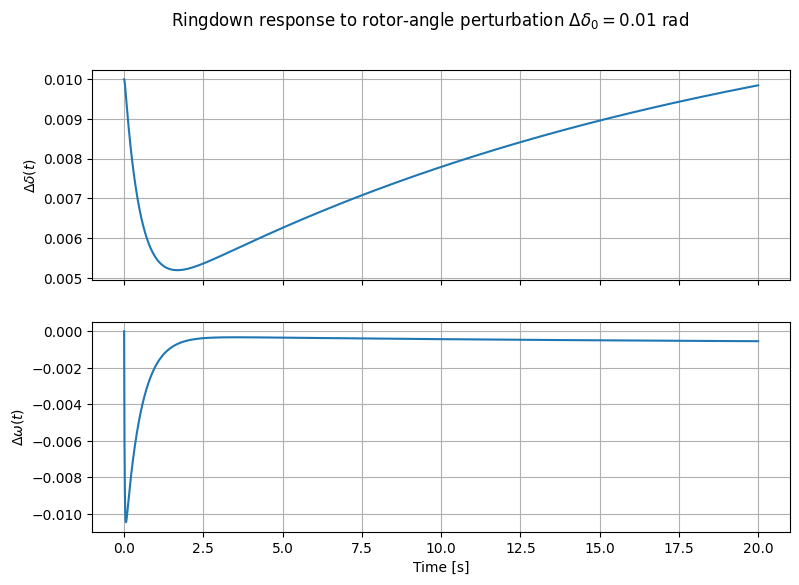

In [55]:
# 1) Baseline equilibrium
x0 = x_star.copy()

# 2) Apply small rotor-angle perturbation
Delta_delta = 0.01  # [rad] try 0.01; later you can sweep 0.005, 0.02, 0.05
x0_pert = x0.copy()
x0_pert[0] += Delta_delta

# 3) Simulate ringdown
t_span, t_eval = set_time(end_time=20.0, interval_points=10000)

sol_ring = solve_ivp(
    synchronous_machine_equations_SM4,
    t_span,
    x0_pert,
    t_eval=t_eval,
    args=(omega_B, H, P_m, X_q_dash, X_d_dash, D,
          T_d_dash, X_d, E_fd, T_q_dash, X_q, Vs, theta_vs),
    rtol=1e-8,
    atol=1e-10,
    method="RK45"
)

# 4) Visualize full state trajectories (same style as your previous plots)
plotting_solution_gridspec_original(sol_ring, model=1)

# 5) Plot deviations from equilibrium (thesis-friendly)
t = sol_ring.t
delta, omega, E_d_dash, E_q_dash = sol_ring.y

d_delta = delta - x_star[0]
d_omega = omega - x_star[1]
d_Ed   = E_d_dash - x_star[2]
d_Eq   = E_q_dash - x_star[3]

fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

axs[0].plot(t, d_delta)
axs[0].set_ylabel(r"$\Delta \delta(t)$")
axs[0].grid(True)

axs[1].plot(t, d_omega)
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel(r"$\Delta \omega(t)$")
axs[1].grid(True)

plt.suptitle(r"Ringdown response to rotor-angle perturbation $\Delta\delta_0 = 0.01$ rad")
plt.show()

In [53]:
import numpy as np

def f_sm4(x):
    """RHS of SM4: x -> dx/dt evaluated at time t=0 (autonomous for constant inputs)."""
    return np.array(
        synchronous_machine_equations_SM4(
            t=0.0,
            x=x,
            omega_B=omega_B,
            H=H,
            P_m=P_m,
            X_q_dash=X_q_dash,
            X_d_dash=X_d_dash,
            D=D,
            T_d_dash=T_d_dash,
            X_d=X_d,
            E_fd=E_fd,
            T_q_dash=T_q_dash,
            X_q=X_q,
            Vs=Vs,
            theta_vs=theta_vs
        ),
        dtype=float
    )

def numerical_jacobian(f, x0, eps=1e-6):
    """
    Central finite-difference Jacobian:
        A[:,i] = (f(x0 + h e_i) - f(x0 - h e_i)) / (2h)
    """
    x0 = np.array(x0, dtype=float)
    n = x0.size
    A = np.zeros((n, n), dtype=float)

    for i in range(n):
        h = eps * max(1.0, abs(x0[i]))  # scale step with magnitude
        dx = np.zeros(n)
        dx[i] = h
        fp = f(x0 + dx)
        fm = f(x0 - dx)
        A[:, i] = (fp - fm) / (2.0 * h)

    return A

In [50]:
A = numerical_jacobian(f_sm4, x_star, eps=1e-6)

print("Jacobian A at x*:")
print(A)

eigvals, eigvecs = np.linalg.eig(A)

# Sort eigenvalues by real part (descending)
idx = np.argsort(np.real(eigvals))[::-1]
eigvals = eigvals[idx]

print("\nEigenvalues of A (sorted by real part):")
for k, lam in enumerate(eigvals):
    print(f"{k+1:>2d}: {lam.real:+.6e} {lam.imag:+.6e}j")

print("\nMode summary (only complex modes):")
for lam in eigvals:
    if abs(lam.imag) > 1e-6:
        sigma = lam.real
        w = abs(lam.imag)              # rad/s
        f_hz = w / (2*np.pi)          # Hz
        tau = -1/sigma if sigma < 0 else np.inf  # decay time constant
        zeta = -sigma / np.sqrt(sigma**2 + w**2) if (sigma != 0 or w != 0) else np.nan
        print(f"lambda = {sigma:+.3e} {lam.imag:+.3e}j | f = {f_hz:.3f} Hz | tau = {tau:.3f} s | zeta = {zeta:.3f}")

Jacobian A at x*:
[[  0.           1.           0.           0.        ]
 [-71.17406742 -62.08681134  13.69815378 -87.2485003 ]
 [  0.13927208   0.          -1.01226994   0.        ]
 [ -0.60234149   0.           0.          -0.8560558 ]]

Eigenvalues of A (sorted by real part):
 1: -5.612431e-02 +0.000000e+00j
 2: -1.006941e+00 +0.000000e+00j
 3: -1.988795e+00 +0.000000e+00j
 4: -6.090328e+01 +0.000000e+00j

Mode summary (only complex modes):


In [51]:
# Use your ringdown solution from earlier
t = sol_ring.t
delta = sol_ring.y[0]
d_delta = delta - x_star[0]

# Remove initial transient offset
signal = d_delta - np.mean(d_delta)

# FFT
dt = t[1] - t[0]
freqs = np.fft.rfftfreq(len(signal), d=dt)
spec = np.abs(np.fft.rfft(signal))

# Ignore DC component
peak_idx = np.argmax(spec[1:]) + 1
f_peak = freqs[peak_idx]

print(f"\nRingdown FFT peak frequency ~ {f_peak:.3f} Hz")


Ringdown FFT peak frequency ~ 0.050 Hz


In [57]:
# eigvals, eigvecs already computed from A
# eigvals sorted the way you did; keep same ordering

print("Mode participation (absolute eigenvector components):")
state_names = ["delta", "omega", "E_d_dash", "E_q_dash"]

for k, lam in enumerate(eigvals):
    v = eigvecs[:, k]
    v_abs = np.abs(v) / np.max(np.abs(v))  # normalize for readability
    parts = ", ".join([f"{state_names[i]}={v_abs[i]:.3f}" for i in range(4)])
    print(f"Mode {k+1}: lambda={lam.real:+.4e} {lam.imag:+.4e}j | {parts}")

print("1/T_q_dash =", 1/T_q_dash)
print("1/T_d_dash =", 1/T_d_dash)

Mode participation (absolute eigenvector components):
Mode 1: lambda=-5.6124e-02 +0.0000e+00j | delta=0.016, omega=1.000, E_d_dash=0.000, E_q_dash=0.000
Mode 2: lambda=-1.0069e+00 +0.0000e+00j | delta=0.503, omega=1.000, E_d_dash=0.072, E_q_dash=0.267
Mode 3: lambda=-1.9888e+00 +0.0000e+00j | delta=1.000, omega=0.056, E_d_dash=0.146, E_q_dash=0.753
Mode 4: lambda=-6.0903e+01 +0.0000e+00j | delta=0.038, omega=0.039, E_d_dash=1.000, E_q_dash=0.153
1/T_q_dash = 0.625
1/T_d_dash = 0.21052631578947367
